In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

/home/hgoz/anaconda3/envs/06-image/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch_directml.is_available():
    device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")

In [3]:
data_mean = 0.1307
data_std = 0.3081
transform = transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((data_mean,), (data_std,))
])

In [4]:
class TripletMNIST(torch.utils.data.Dataset):

  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):  
    anchor = self.data[index][0]
    label = self.data[index][1]   

    # Get positive sample 
    while True:     
      x, y = self.data[random.randint(0, len(self.data) - 1)]
      if y == label:
        positive = x
        break

    # Get negative sample       
    while True:
        x, y = self.data[random.randint(0, len(self.data) - 1)]
        if y != label:
          negative = x
          break

    return anchor, positive, negative, label

In [5]:
minst_train, mnist_valid = torch.utils.data.random_split(MNIST(root='data', train=True, download=True, transform=transform),
                                                         [50_000, 10_000])
trainset = TripletMNIST(minst_train)

In [6]:
classes = (
    'Zero',   
    'One',    
    'Two',   
    'Three',  
    'Four',    
    'Five', 
    'Six',  
    'Seven',  
    'Eight',   
    'Nine'  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 8


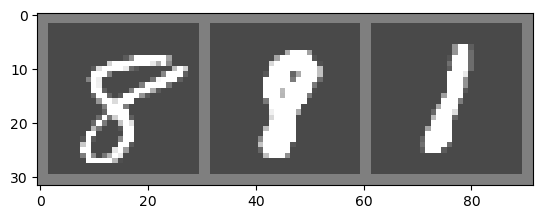

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
anchor, positive, negative, label = trainset[1]

# show images
print('Label:', label)
imshow(torchvision.utils.make_grid([anchor, positive, negative]))

In [8]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super(PatchEmbed, self).__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self, img_size, d_model, patch_size, nhead, num_layers):
        super(Encoder, self).__init__()
        self.embed = PatchEmbed(img_size*img_size, patch_size, 1, d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model), num_layers=num_layers)
        
    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        return x.flatten(1)

In [10]:
class Model(nn.Module):
    def __init__(self, img_size, d_model, patch_size, nhead, num_layers, n_classes):
        super(Model, self).__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)

        self.encoder = Encoder(img_size, d_model, patch_size, nhead, num_layers)
        self.classifier = nn.Linear(d_model * num_patches, n_classes)
    
    def forward(self, x):
        s = self.encoder(x)
        preds = self.classifier(s)
        return s, preds

In [11]:
criterion_triplet = nn.TripletMarginWithDistanceLoss(margin=1.0) 
criterion_class = nn.CrossEntropyLoss()

In [12]:
def calc_accuracy(preds, labels):
    num_correct = (preds == labels).float().sum().item()
    return num_correct / preds.shape[0]


In [13]:
MODEL_PATH = 'mnist_contrastive.pth'
model = Model(img_size=28, d_model=32, patch_size=7, nhead=16, num_layers=2, n_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_params = sum(p.numel() for p in model.parameters())
num_params

19658

In [14]:
loss_avg = 0
accuracies = []

In [15]:
batch_size = 50
trainset_loader = DataLoader(trainset, batch_size=batch_size, num_workers=4, shuffle=True)
validset_loader = DataLoader(mnist_valid, batch_size=batch_size, num_workers=4, shuffle=True)

In [23]:
from tqdm import tqdm

for epoch in range(3):
    model.train()
    tqdm_bar = tqdm(trainset_loader)
    for data in tqdm_bar:
        anchors = data[0].to(device)
        positives = data[1].to(device)
        negatives = data[2].to(device)
        labels = data[3].to(device)
    
        embeddings, class_outputs = model(anchors)
        pos_embeddings, _ = model(positives) 
        neg_embeddings, _ = model(negatives)  

        # loss_triplet = criterion_triplet(embeddings, pos_embeddings, neg_embeddings)
        loss_class = criterion_class(class_outputs, labels)

        # loss = loss_triplet + loss_class
        # loss = loss_triplet
        loss = loss_class

        loss_avg = 0.9 * loss_avg + 0.1 * loss.item() 
        tqdm_bar.set_postfix(loss="{:05.3f}".format(loss_avg))

        optimizer.zero_grad()   
        loss.backward()     
        optimizer.step()

    # Evaluate on Validation Set
    model.eval()
    with torch.no_grad():
        for data in validset_loader:
            images = data[0].to(device)
            labels = data[1].to(device)
            _, outputs = model(images)
            preds = outputs.argmax(dim=1)
            accuracies.append(calc_accuracy(preds, labels))
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Accuracy: {avg_accuracy:.3f}")
    torch.save(model.state_dict(), MODEL_PATH)

100%|██████████| 1000/1000 [01:28<00:00, 11.25it/s, loss=0.131]


Accuracy: 0.745


100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s, loss=0.107]


Accuracy: 0.789


100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s, loss=0.106]


Accuracy: 0.819


In [17]:
# model.load_state_dict(torch.load(MODEL_PATH))
# model.to(device)

1. The Model has been trained with just `loss_triplet` for `30` epochs
2. Then it was trained with just `loss_Class` for `5` epochs

In [24]:
batch_size = 10
mnist_test = MNIST(root='data', train=False, download=True, transform=transform)
testset = mnist_test
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [25]:
accuracies = []
model.eval()
with torch.no_grad():
    for data in validset_loader:
        images = data[0].to(device)
        labels = data[1].to(device)
        _, outputs = model(images)
        preds = outputs.argmax(dim=1)
        accuracies.append(calc_accuracy(preds, labels))
avg_accuracy = sum(accuracies) / len(accuracies)
print(f"Accuracy on test set: {avg_accuracy:.3f}")

Accuracy on test set: 0.971


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        _, outputs = model(images)
        preds = outputs.argmax(dim=1)
        accuracies.append(calc_accuracy(preds, labels))
        # collect the correct predictions for each class
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Zero  is 99.5 %
Accuracy for class: One   is 99.2 %
Accuracy for class: Two   is 97.4 %
Accuracy for class: Three is 93.8 %
Accuracy for class: Four  is 97.8 %
Accuracy for class: Five  is 97.8 %
Accuracy for class: Six   is 97.2 %
Accuracy for class: Seven is 96.9 %
Accuracy for class: Eight is 94.4 %
Accuracy for class: Nine  is 95.0 %
